# Plant Disease Classifier using ResNet152 

<h2>Installing and Importing Libraires</h2>

In [ ]:
!pip install Pillow==5.3.0
!pip install image
!pip install torchvision==0.2.2
!pip install torch==0.4.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


<h2>Extracting the data</h2>
The data is a tar.xz file which we will extract here. 

In [4]:
#Extracting the data set
!tar -xf data-split.tar.xz

## Processing the Data
We will be using the organised data, and will be transforming it. The data to be transformed is the train and validation data. 

This data will then be loaded with ImageFolder.

In [5]:
#Creating the labels
import json

with open('label.json', 'r') as f:
    categories = json.load(f)

In [6]:
#Organizing the dataset
data_dir = 'data-split'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()
use_gpu

True

In [7]:
print(categories)

{'Apple-Scab': 'Apple-Scab', 'Black-Rot': 'Black-Rot', 'Healthy': 'Healthy', 'Cedar-Apple-Rust': 'Cedar-Apple-Rust'}


In [8]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
# Load the datasets with ImageFolder

data_dir = 'data-split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

<h2>Building and training the classifier</h2>
We will now build and train the classifier. We will use one of the pretrained models from torchvision.models to get the image features. We will then Build and train a new feed-forward classifier using those features. 

Resnet-152 pretrained model is used for this image classifier.

In [10]:
# Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

#Checking the model architecture:
    print(model)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Streaming output truncated to the last 5000 lines.
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (21): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
# Defining a new, untrained feed-forward network as a classifier, using ReLU activations

# Our input_size matches the in_features of pretrained model
from collections import OrderedDict

# Creating the classifier ordered dictionary first
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.fc = classifier

In [12]:
#Creating function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
# Train a model with a pre-trained network
num_epochs = 10
if use_gpu == True :
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

Using GPU: True
Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5722 Acc: 0.7843
valid Loss: 0.1877 Acc: 0.9373

Epoch 2/10
----------
train Loss: 0.2866 Acc: 0.8975
valid Loss: 0.1302 Acc: 0.9498

Epoch 3/10
----------
train Loss: 0.2454 Acc: 0.9085
valid Loss: 0.0680 Acc: 0.9812

Epoch 4/10
----------
train Loss: 0.2447 Acc: 0.9172
valid Loss: 0.2272 Acc: 0.9279

Epoch 5/10
----------
train Loss: 0.2075 Acc: 0.9271
valid Loss: 0.0656 Acc: 0.9781

Epoch 6/10
----------
train Loss: 0.1689 Acc: 0.9393
valid Loss: 0.0650 Acc: 0.9781

Epoch 7/10
----------
train Loss: 0.1608 Acc: 0.9444
valid Loss: 0.0642 Acc: 0.9749

Epoch 8/10
----------
train Loss: 0.1581 Acc: 0.9409
valid Loss: 0.0620 Acc: 0.9781

Epoch 9/10
----------
train Loss: 0.1631 Acc: 0.9353
valid Loss: 0.0650 Acc: 0.9781

Epoch 10/10
----------
train Loss: 0.1412 Acc: 0.9464
valid Loss: 0.0571 Acc: 0.9812

Training complete in 8m 29s
Best valid accuracy: 0.981191


<h2>Save the checkpoint</h2>
Now that the network is trained, we will save the model so we can load it later for making predictions. We will save the mapping of classes to indices which we get from one of the image datasets: image_datasets['train'].class_to_idx. We will attach this to the model as an attribute which makes inference easier later on.

model.class_to_idx = image_datasets['train'].class_to_idx

In [19]:
# Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'model-ResNet154.pth')

<h2>Loading the checkpoint</h2>
No we write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [21]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 39
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('model-ResNet154.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

<h2>Inference for classification</h2>
Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the plant disease in the image. 
We'll write a function called predict that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities.

In [22]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [23]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<h2>Class Prediction</h2>
Once we can get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We will calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor we use x.topk(k). 
This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using class_to_idx which we added to the model or from an ImageFolder we used to load the data.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

In [32]:
def predict(image_path, model, topk=4):
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx[:-1]]
    top_probability = pobabilities[top_idx[:-1]]

    return top_probability, top_class

In [37]:
pred = predict('/content/data-split/test/Black-Rot/Black-Rot496.jpg', loaded_model)
print("Label : ",pred[1][0])
print("Accuracy : {0:.2f}%".format(pred[0][0]*100))

Label :  Black-Rot
Accuracy : 99.73%


## Predictions
Now that we can use a trained model for predictions, we check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. 
Using matplotlib to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

In [43]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()
    print("Accuracy = {0:.2f}%".format(probabilities[0]*100))

Accuracy = 99.60%


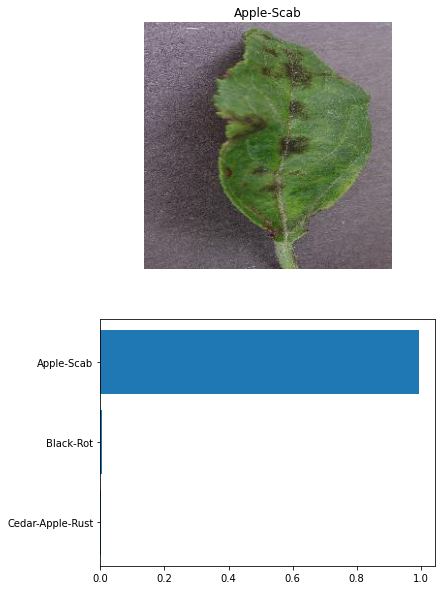

In [44]:
img = '/content/data-split/test/Apple-Scab/Apple-Scab521.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, categories)

Accuracy = 99.87%


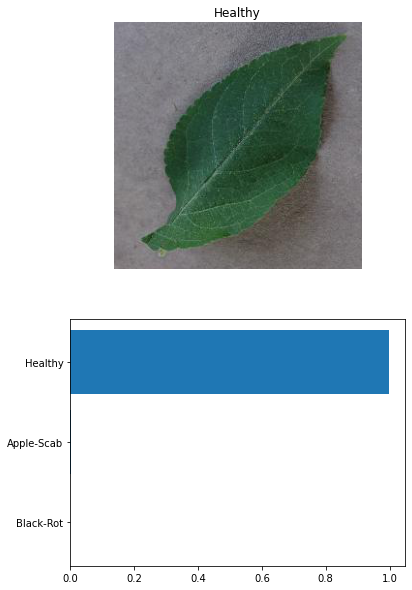

In [45]:
img = '/content/data-split/test/Healthy/Healthy1340.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, categories)

Accuracy = 95.95%


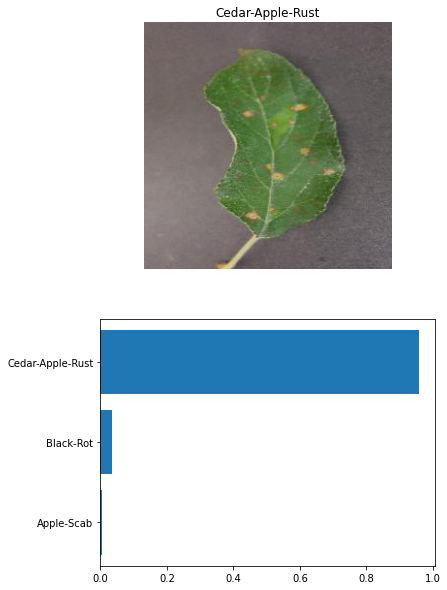

In [46]:
img = '/content/data-split/test/Cedar-Apple-Rust/Cedar-Apple-Rust242.jpg'
p, c = predict(img, loaded_model)
view_classify(img, p, c, categories)